# Test: Data Scientist (Client2) - SyftBox Mode

Automated test notebook for the Data Scientist workflow with SyftBox encryption.
Run with: `jupyter execute sc_test_ds.ipynb`

In [1]:
!pip install -q --force-reinstall --no-deps $(ls -t ../../syftbox-sdk/python/target/wheels/syftbox_sdk-*arm64.whl | head -1)
!pip install -e ../../python --upgrade -q --upgrade

In [2]:
!uv pip install scikit-misc

Audited 1 package in 3ms


In [3]:
import sys
from pathlib import Path

# Configuration
TIMEOUT = 120.0
USER_EMAIL = "client2@sandbox.local"
PEER_EMAIL = "client1@sandbox.local"
DATA_DIR = Path.cwd()

In [4]:
!uv pip install scanpy

Audited 1 package in 13ms


In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
from beaver import Twin
import beaver

# Connect with SyftBox backend
bv = beaver.connect(
    user=USER_EMAIL,
    data_dir=DATA_DIR,
)
print(f"[DS] Connected as {bv.user}")
print(f"[DS] SyftBox enabled: {bv.syftbox_enabled}")

🔄 Auto-load replies enabled for client2@sandbox.local (polling every 2.0s)
[DS] Connected as client2@sandbox.local
[DS] SyftBox enabled: True


In [6]:
# Request a session with the data owner
print(f"[DS] Requesting session with {PEER_EMAIL}...")
session = bv.request_session(
    peer_email=PEER_EMAIL,
    message="Requesting access for single-cell analysis test"
)

print(f"[DS] Session requested: {session.session_id}")
print(f"[DS] Waiting for session acceptance...")

# Wait for session to be accepted
session.wait_for_acceptance(timeout=TIMEOUT)
print(f"[DS] ✓ Session accepted!")

[DS] Requesting session with client1@sandbox.local...
📤 Session request sent to client1@sandbox.local
   Session ID: 09c7e8e6c1d1
   Use session.wait_for_acceptance() to wait for approval
[DS] Session requested: 09c7e8e6c1d1
[DS] Waiting for session acceptance...
⏳ Waiting for client1@sandbox.local to accept session 09c7e8e6c1d1...
📁 Created session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1
✅ Session 09c7e8e6c1d1 accepted!
[DS] ✓ Session accepted!


In [7]:
# Load Twin from session - use peer_remote_vars to read DO's data
import time

print("[DS] Waiting for Twin to be published...")
patient_sc = None
deadline = time.monotonic() + TIMEOUT

while time.monotonic() < deadline:
    try:
        # peer_remote_vars reads from peer's session folder
        patient_sc = session.peer_remote_vars["patient_sc"].load(auto_accept=True)
        if patient_sc is not None:
            break
    except (KeyError, Exception):
        pass
    time.sleep(1.0)

assert patient_sc is not None, "Failed to load Twin"
assert hasattr(patient_sc, 'public'), "Twin has no public attribute"
print(f"[DS] Loaded Twin: {patient_sc}")
print(f"[DS] Public data: {patient_sc.public.n_obs} cells")

[DS] Waiting for Twin to be published...
⏳ Waiting for artifact file to sync: patient_sc_public.bin
⠧ syncing patient_sc_public.bin (989,936,086 bytes)
✓ Artifact file synced: patient_sc_public.bin (989,936,086 bytes)
✓ Loaded Twin 'patient_sc' from published location
[DS] Loaded Twin: 🌍 Twin: patient_sc (MOCK DATA - SAFE)
  🔒 Private    (not available) 💡 .request_private()
  🌍 Public    <AnnData (preview): AnnData n_obs=30000, n_vars=36601 — r...    ← .value uses this
  Owner: client1@sandbox.local
  Live: ⚫ Disabled
  IDs: twin=8dc3f1c2... private=e03fd189... public=ed201a00...
[DS] Public data: 30000 cells


## Step 1: Violin Plot

In [8]:
session.peer_remote_vars

Name,Type,ID
patient_sc,"Twin[AnnData] (30000, 36601)",56066816a9e0...


In [9]:
patient_sc

🌍 Twin: patient_sc (MOCK DATA - SAFE)
  🔒 Private    (not available) 💡 .request_private()
  🌍 Public    <AnnData (preview): AnnData n_obs=30000, n_vars=36601 — r...    ← .value uses this
  Owner: client1@sandbox.local
  Live: ⚫ Disabled
  IDs: twin=8dc3f1c2... private=e03fd189... public=ed201a00...

In [10]:
print("[DS] Running violin plot analysis...")

@bv
def make_violin(adata):
    print("n_cells:", adata.n_obs)
    sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)
    return plt.gcf()

violin_result = make_violin(patient_sc)

assert violin_result is not None, "Violin computation returned None"
assert hasattr(violin_result, 'public'), "Result has no public attribute"
print(f"[DS] Violin public stdout: {violin_result.public_stdout[:50]}...")

[DS] Running violin plot analysis...
[DS] Violin public stdout: n_cells: 30000
...


In [11]:
violin_result

⚠️  Twin: make_violin_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━...    ← .value uses this
  🌍 Public    <Figure size 1511.11x500 with 3 Axes>    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 15 chars
  📊 Captured figures: 2
  IDs: twin=56c4094d... private=8fc43b62... public=489eb5f6...
  💡 Access: .public_stdout, .public_stderr, .public_figures

📊 Public figures (2):


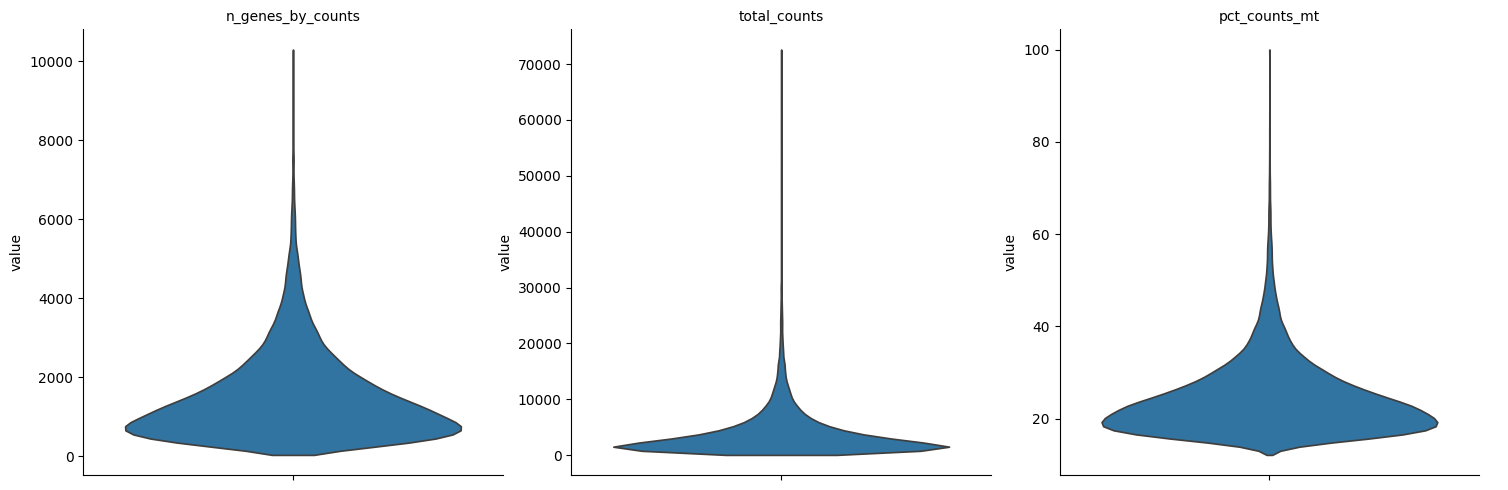

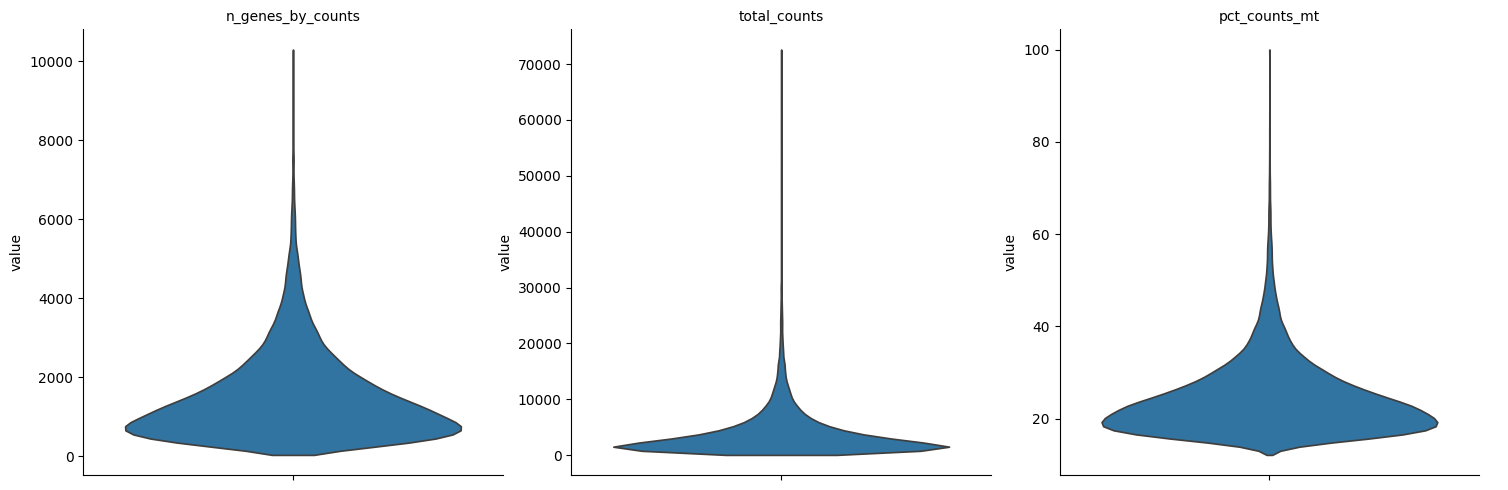

In [12]:
# Display captured figures for mock run
violin_result.show_figures('public')


In [13]:
print("[DS] Requesting private execution...")
violin_result.request_private()

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: make_violin
   Result: violin_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1/1e59a65aed014090b2aa0ec0b737557e.beaver
💡 Result will auto-update when client1@sandbox.local approves


In [14]:
print("[DS] Waiting for violin result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for violin result"

assert violin_result.private is not None, "Private result not received"
print(f"[DS] ✓ Violin private result received")
if violin_result.private_stdout:
    print(f"[DS] Private stdout: {violin_result.private_stdout[:50]}...")

[DS] Waiting for violin result...
📬 New message: make_violin_result
   From: client1@sandbox.local
[DS] ✓ Violin private result received


## Step 2: Embedding Plot

In [15]:
print("[DS] Running embedding analysis...")

@bv
def show_embedding(adata):
    print("n_cells:", adata.n_obs)
    return sc.pl.embedding(
        adata,
        basis='X_umap',
        color=['pct_counts_mt', 'cell_type'],
        ncols=1, size=15,
        frameon=False,
        show=False
    )

embedding_result = show_embedding(patient_sc)

assert embedding_result is not None, "Embedding computation returned None"
print(f"[DS] Embedding public figures: {len(embedding_result.public_figures)}")

[DS] Running embedding analysis...
[DS] Embedding public figures: 1


In [16]:
print("[DS] Requesting private execution...")
embedding_result.request_private()

print("[DS] Waiting for embedding result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for embedding result"

print(f"[DS] ✓ Embedding private result received")

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: show_embedding
   Result: embedding_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1/2b674f79673f4fda9dc0d64f7e0b9fa5.beaver
💡 Result will auto-update when client1@sandbox.local approves
[DS] Waiting for embedding result...
📬 New message: show_embedding_result
   From: client1@sandbox.local
[DS] ✓ Embedding private result received


## Step 3: PCA Variance

In [17]:
print("[DS] Running PCA variance analysis...")

@bv
def plot_pca_variance(adata):
    adata.layers['raw_counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw_counts', n_top_genes=5000)
    sc.pp.pca(adata, use_highly_variable=True)
    with plt.rc_context({'figure.figsize': (4, 3)}):
        sc.pl.pca_variance_ratio(adata, n_pcs=50)

pca_result = plot_pca_variance(patient_sc)

assert pca_result is not None, "PCA computation returned None"
print(f"[DS] PCA public figures: {len(pca_result.public_figures)}")

[DS] Running PCA variance analysis...
[DS] PCA public figures: 2


In [18]:
print("[DS] Requesting private execution...")
pca_result.request_private()

print("[DS] Waiting for PCA result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for PCA result"

print(f"[DS] ✓ PCA private result received")

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: plot_pca_variance
   Result: pca_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1/c08e705475a34e7faa45a980fad804f7.beaver
💡 Result will auto-update when client1@sandbox.local approves
[DS] Waiting for PCA result...
📬 New message: plot_pca_variance_result
   From: client1@sandbox.local
[DS] ✓ PCA private result received


## Step 4: UMAP Embedding

In [19]:
print("[DS] Running UMAP embedding analysis...")

@bv
def umap_embedding(adata):
    sc.pp.neighbors(adata, n_pcs=50)
    sc.tl.umap(adata)
    return sc.pl.embedding(
        adata,
        basis='X_umap',
        color=['cell_type'],
        ncols=1, size=15,
        frameon=False,
        show=True
    )

umap_result = umap_embedding(patient_sc)

assert umap_result is not None, "UMAP computation returned None"
print(f"[DS] UMAP public figures: {len(umap_result.public_figures)}")

[DS] Running UMAP embedding analysis...
[DS] UMAP public figures: 2


In [20]:
print("[DS] Requesting private execution...")
umap_result.request_private()

print("[DS] Waiting for UMAP result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for UMAP result"

print(f"[DS] ✓ UMAP private result received")

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: umap_embedding
   Result: umap_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/09c7e8e6c1d1/bca95c9e59784b65ad52e2e9d34b99ad.beaver
💡 Result will auto-update when client1@sandbox.local approves
[DS] Waiting for UMAP result...
📬 New message: umap_embedding_result
   From: client1@sandbox.local
[DS] ✓ UMAP private result received


In [21]:
# Final verification
print("\n" + "="*50)
print("[DS] TEST PASSED")
print("[DS] Successfully completed all 4 analysis steps:")
print("  1. Violin plot")
print("  2. Embedding plot")
print("  3. PCA variance")
print("  4. UMAP embedding")
print("="*50)

# Verify inbox has all results
inbox = bv.inbox()
print(f"\n[DS] Inbox contains {len(inbox)} messages")
assert len(inbox) >= 4, f"Expected at least 4 results in inbox, got {len(inbox)}"


[DS] TEST PASSED
[DS] Successfully completed all 4 analysis steps:
  1. Violin plot
  2. Embedding plot
  3. PCA variance
  4. UMAP embedding

[DS] Inbox contains 4 messages
